<a href="https://colab.research.google.com/github/seank1m/artificial-intelligence-for-robotics/blob/main/Tutorial3_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Support Vector Machine (SVM)

Support Vector Machine (SVM) is a learning algorithm used in supervised learning settings, whether it be for classification or regression analysis. SVM requires the dataset to be labeled. In terms of classification, SVMs can perform linear and non-linear classification. Linear classification is when the hyperplane that separates the classes is defined as a linear function. For this tutorial, we will focus on linear classification and at the end look at a case where the classes are not linear separable.

# Setup
Firstly, we'll be generating some toy data to better visualise the problem and algorithms. To easily visualize the data, we will create a set of 2D data points. However, keep in mind that SVM can both be applied to multi-dimensional data. The setup is similar to what we did in the last tutorial.

In [2]:
# installing libraries that we need to run SVMs
%pip install numpy scipy

# importing the above-installed libraries
import numpy as np
import scipy

In [3]:
# installing libraries that we need to visualize data
%pip install matplotlib plotly

# importing the above-installed libraries
from matplotlib import pyplot as plt
from plotly import express as px, graph_objects as go

Let's create a 2D toy dataset. The dataset will have 2 clusters with each cluster having 100 data points. A data point is represented using its 2D position on the Cartesian (xy) space. Thus, each data point has 2 features: x position and y position.
We will first define our clusters as Gaussian ellipses and later sample 100 points from the ellipses. The formal definition of an ellipse can be written as
$$
\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1 , \text{where } a \ge b > 0 .\\
$$
Here $a$ is referred to as the width of the ellipse or the semi-major axis and $b$ is the height of the ellipse or the semi-minor axis.
The above equation results in an ellipse with its center at the origin. However if we want to shift it to a different location, the center position needs to be specified.
Thus, below we define values for each cluster, 2D values for the centers or `mean`s, values for $a$ `major` axis and values for $b$ `minor` axis.
Additionally, we define `angle`s to rotate the clusters.

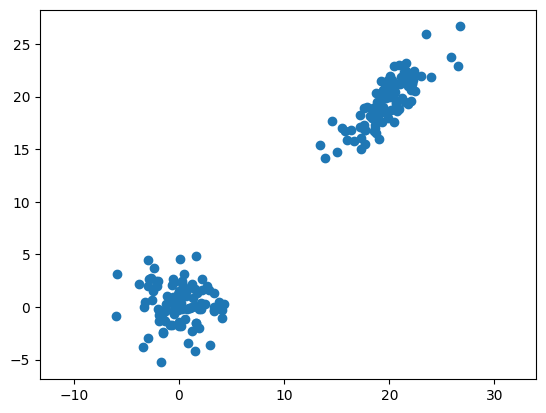

In [4]:
from math import pi
rng = np.random.default_rng(4)  # Random Number Generator

n_clusters = 2  # Number of clusters
n_points_per_cluster = 100  # Number of data points per cluster
n_points = n_points_per_cluster * n_clusters  # total Number of data points

# Let's manually create some clusters
mean = np.array([[0, 0], [20, 20]])  # Mean 2D position of the 2 clusters
major = np.array([2, 3])  # Semi-major axis of the clusters (a)
minor = np.array([2, 1])  # Semi-minor axis of the clusters (b)
angle = np.array([0, pi/4])  # Angle of rotation of the clusters
assert all(minor <= major)

clusters = []
covs = []

for mn, mj, mi, a in zip(mean, major, minor, angle):
    c = np.cos(a) # cosine of the angle
    s = np.sin(a) # sine of the angle
    R = np.array([
        [c,-s],
        [s, c],
    ])  # 2D rotation matrix as per the specified angle
    D = np.array([
        [mj**2, 0],
        [0, mi**2],
    ]) # Diagonal matrix consisting of major and minor axis values
    cov = R @ D @ R.T # Covariance of the ellipse (rotated)
    covs.append(cov)
    clusters.append(
        rng.multivariate_normal(
            mn, cov,
            size=n_points_per_cluster,
        ),  # Generate 100 random points from a multivariant normal with the specified mean and covariance.
    )

points = np.concatenate(clusters, axis=0)  # Concatenate all points in axis 0 resulting in [200, 2] vector.
# Depending on your dataset these points will have the shape of [number of data points, number of features]

# Let's plot the points using the scatter function
plt.scatter(points[:,0], points[:,1])
plt.axis('equal')
plt.show()

As stated in the beginning, an SVM requires the data to be labeled. We created the dataset but now we need to label it. Let's define cluster 1 to have label `-1` and cluster 2 to have label `+1`.

In [9]:
# Creating labels
labels = np.zeros(n_points)
labels[:n_points_per_cluster] = -1
labels[n_points_per_cluster:] = +1

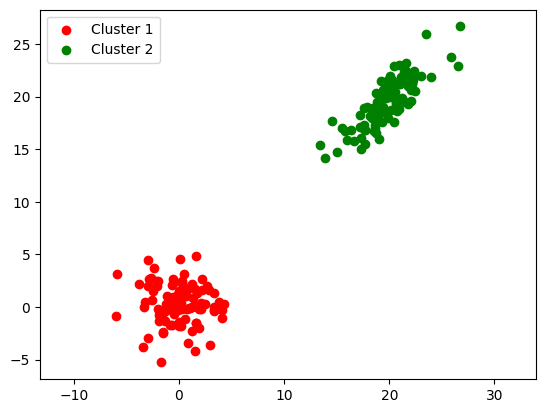

In [10]:
# Let's visualize each cluster separately as generated
def plot_points(points, labels):
  for label, color in zip([-1,+1], 'rg'):
    plt.scatter(points[labels == label, 0], points[labels == label, 1], c=color)
  plt.legend(['Cluster 1', 'Cluster 2'])
  plt.axis('equal')

plot_points(points, labels)
plt.show()

# Linear SVM Algorithm

We are given a training dataset of $n$ points in the form

$$
\{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_i, y_i), (\mathbf{x}_n, y_n)\}
$$

where $\mathbf{x}_i$ is a data point with $d$ dimensions and $y_i \in \{-1, +1\}$ is the class label.

The idea of SVM is to find the *maximum-margin hyperplane* that separates these two classes. This hyperplane is located such that the distances from the closest points from each class to the plane are maximized. These closest points are referred to as *support vectors*.

Mathematically, a hyperplane can be written as:
$$
\mathbf{w}^T \mathbf{x} - b = 0  \tag{1}
$$

Here $\mathbf{w}$ is the normal vector to the hyperplane. The distance from the hyperplane to the origin is defined to be $\frac{b}{||\mathbf{w}||}$, where $||\mathbf{w}||$ is the magnitude of the weight vector $\mathbf{w}$.

In cases where the two classes are linearly separable, we can define two parallel hyperplanes to separate the classes such that the distance between the two is maximized. The area between the hyperplanes is termed the *margin*. The *maximum-margin hyperplane* lies in between the two.
The equations for these two hyperplanes are thus:
$$
\mathbf{w}^T \mathbf{x} - b = +1  \tag{2}
$$
$$
\mathbf{w}^T \mathbf{x} - b = -1  \tag{3}
$$

For $(2)$: any data point on or above this boundary belongs to the class with label $+1$; and for $(3)$: any data point on or below this boundary belongs to the class with label $-1$.
The distance between the two hyperplanes, the *margin*, is thus $\frac{2}{||\mathbf{w}||}$.
To realize the *maximum-margin hyperplane*, we need to maximize this distance, meaning we need to minimize $||\mathbf{w}||$.

One additional constraint we need to remember is to have no points on the wrong side of the margin. This can be formulated in the following manner:
$$
\mathbf{w}^T \mathbf{x}_i - b \ge +1  \quad\text{if}\ y_i = +1
$$
$$
\mathbf{w}^T \mathbf{x}_i - b \le -1  \quad\text{if}\ y_i = -1
$$
The left side of the equation is the distance to the hyperplane.
Putting the equations together, we can write:
$$
y_i(\mathbf{w}^T\mathbf{x}_i - b) \ge 1 \quad
\forall i \in \{1,...,n\}
$$

Thus our optimization simplifies to:
$$
\min_{\mathbf{w}, b} ||\mathbf{w}||_2^2 \\
\text{such that } y_i(\mathbf{w}^T \mathbf{x}_i - b) \ge 1\,,\; \forall i \in \{1,...,n\}
$$

## Soft-Margin

To extend this framework to the case where the classes are *not* linearly separable, a *soft-margin* classifier is created by adding a penalty for points on the wrong side of the margin:
$$
\min_{\mathbf{w}, b, \boldsymbol{\zeta}} ||\mathbf{w}||_2^2
  + C \sum_{i=1}^n \zeta_i
\\
\text{such that }
  y_i(\mathbf{w}^T \mathbf{x}_i - b) \ge 1 \,,\;
  \zeta_i \ge 0 \,,\;
  \forall i \in \{1,...,n\}
$$
Here $C$ is a weighting parameter: with a sufficiently large $C$, the algorithm behaves as a hard-margin classifier.

## Dual Problem

The above optimization problem can be simplified in the following manner using the Lagrangian dual (which we will not discuss in depth in this subject).
$$
\max_{\mathbf{c}}
  \sum_{i=1}^n c_i
  - \frac12
    \sum_{i=1}^n
    \sum_{j=1}^n
    c_i y_i (\mathbf{x}_i^T \mathbf{x}_j) y_j c_j
\\
\text{such that }
  \sum_{i=1}^n c_iy_i = 0 \,,\;
  0 \le c_i \le \frac1{2n\lambda}\,,\;
  \forall i \in \{1,...,n\} \tag{4}
$$

The soft-margin weighting parameter $C$ is here replaced by the inversely related $\lambda$: small values of $\lambda$ produce a hard-margin classifier.

Instead of *minimising* with respect to the variables $\mathbf{w}$, $b$, and $\boldsymbol{\zeta}$, the dual form *maximizes* with respect to the *dual variables* $\mathbf{c}$.
Based on the quadratic programming solution in $\mathbf{c}$, the original variable $\mathbf{w}$ can be calculated as:
$$
\mathbf{w} = \sum_{i=1}^n c_i y_i \mathbf{x}_i \tag{5}
$$
After optimisation, most $c_i$ should be zero (or close to zero), where $\mathbf{x}_i$ lies on the correct side of the margin. For the few $\mathbf{x}_i$ that lie *on* the margin boundary itself, the associated $c_i$ are non-zero: these are termed the *support vectors*. Thus, $\mathbf{w}$ is the weighted (by $c_i$) sum of these support vectors.

Likewise, $b$ can be calculated by first finding a $\mathbf{x}_i$ on the margin's boundary, and using the below relation:
$$
b = \mathbf{w}^T \mathbf{x}_i - y_i \tag{6}
$$

The dual problem can be efficiently solved using quadratic programming algorithms. In this tutorial, we will use the `solve_qp` function from `qpsolvers` Python library.

In [5]:
# install the quadratic solvers
%pip install qpsolvers
import qpsolvers
from qpsolvers import solve_qp
solver = qpsolvers.available_solvers[0]
qpsolvers.available_solvers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.1 MB/s eta 0:00:00


['clarabel', 'cvxopt', 'highs', 'osqp', 'scs']

# Quadratic Program

The objective of a quadratic programming problem is to find $n$-dimensional $\mathbf{x}$ which minimizes the following set up.
$$
\min \frac{1}{2}\mathbf{x}^TP\mathbf{x} + \mathbf{q}^T\mathbf{x} \\
\text{subject to }
  G \mathbf{x} \le h \,,\;
  A\mathbf{x} = b \,,\;
  lb \le \mathbf{x} \le ub
\tag{7}
$$

<!-- * $\mathbf{x}$ is $n$-dimensional vector
* $\mathbf{q}$ is $n$-dimensional and real-valued vector
* P is $n\times n$-dimensional and real symmetric matrix
* G is $m\times n$-dimensional and real matrix
* $\mathbf{h}$ is $m$-dimensional and real-valued vector -->
Equality constraints are defined in terms of by $A$ and $b$, and inequality constraints in terms $G$ and $h$ or $lb$ and $ub$. Based on the optimization problem, you need to define these values.

## Helpful Hints

1. The dot product between two vectors of the same length is the same as matrix multiplication of one with the other's transpose.
$$
\mathbf{a} \cdot \mathbf{x} =
\mathbf{a}^T \mathbf{x} =
\sum_i a_i x_i
$$

2. If you have a $n$ dimensional vector $\mathbf{x}$ and a $n \times n$ matrix $A$, you can write the following:
$$
\mathbf{x}^T A \mathbf{x} = \sum_i^n \sum_j^n x_i a_{ij} x_j
$$

<!-- The objective function (4) can be modified to look as follows:
$$
\min_{\mathbf{c}}
  - \mathbf{1}_{n\times1}^T \mathbf{c}
  + \frac12
    \mathbf{c}^T
    A
    \mathbf{c} \tag{5}
\\
$$ -->

<!-- where A can be of the following form:
$$
A^1_{n\times m} A^2_{m\times n} = A_{n\times n}
\\
a_{i,k} = \sum_{k=1}^m a^1_{i,j} a^2_{j,k}
$$ -->


Hint: Compare these identities and equation (7) to equation (4) to derive answers for the questions below.

## Dual Problem
$$
\max_{\mathbf{c}}
  \sum_{i=1}^n c_i
  - \frac12
    \sum_{i=1}^n
    \sum_{j=1}^n
    c_i y_i (\mathbf{x}_i^T \mathbf{x}_j) y_j c_j
\\
\text{such that }
  \sum_{i=1}^n c_iy_i = 0 \,,\;
  0 \le c_i \le \frac1{2n\lambda}\,,\;
  \forall i \in \{1,...,n\} \tag{4}
$$

# Quadratic Program

The objective of a quadratic programming problem is to find $n$-dimensional $\mathbf{x}$ which minimizes the following set up.
$$
\min \frac{1}{2}\mathbf{x}^TP\mathbf{x} + \mathbf{q}^T\mathbf{x} \\
\text{subject to }
  G \mathbf{x} \le h \,,\;
  A\mathbf{x} = b \,,\;
  lb \le \mathbf{x} \le ub
\tag{7}
$$

In [11]:
# TODO fill in the following assignments to solve the quadratic equation
n = points.shape[0] # total number of data points, should be 200
x = points # data points of shape [n,f] where f is the number of features
y = labels # label values of shape [n]
y = y.astype(float) # solver requires floats not integers
l = 1e-5  # lambda

xy = x*y [:, None] # shape [n, f], gives values of x times by y
P =  xy @ xy.T # shape [n, n]
q = -1*np.ones(n) # shape [n]

n_eq_constr = 3 # number of equality constraints
n_ineq_constr = 3 # number of inequality constraints

A = y[None, :] # shape [n_eq_constr, n]
b = np.zeros(1)    # shape [n_eq_constr]

# It is easier to give the inequality constraints via the lb and ub arguments

G = None # shape [n_ineq_constr, n]
h = None # shape [n_ineq_constr]
lb = np.zeros(n) # shape [n]
ub = (1/(2*n*1)) * np.ones(n) # shape [n]

c = solve_qp(P, q, G, h, A, b, lb, ub, solver=solver)
# Note when c is closer to zero it is on the correct side fo the boundary and non-zero c represent support vectors.

/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


## Helpful Hints

1. The dot product between two vectors of the same length is the same as matrix multiplication of one with the other's transpose.
$$
$$
$$
\mathbf{a} \cdot \mathbf{x} =
\mathbf{a}^T \mathbf{x} =
\sum_i a_i x_i
$$

$$
\mathbf{w} = \sum_{i=1}^n c_i y_i \mathbf{x}_i \tag{5}
$$

$$
$$

$$
b = \mathbf{w}^T \mathbf{x}_i - y_i \tag{6}
$$

In [12]:
# Calculate the weights
w = c @ xy # Use equation (5)
# c_i * y_i * x_i = c . xy

# First calculate the support vectors.
# Hint: Support vectors have non-zero c values. We can find them by figuring out how many c values are non-zero (greater than a threshold value).
# Use l as your threshold. We need to go about this way due to floating point issues of zero.

sv = (c > 1) # all values from C vector that are greater than 1

n_support_vectors =len(sv)

# print(n_support_vectors)

# Use equation (6) to calculate b value for each support vector
b_sv = x[sv] @ w - y[sv] #w @ x[sv].T - y[sv]

# TODO If the problem is linearly seperable what can you say about the b values derived from each support vector?

# Average to achieve a single b value
b = b_sv.mean()


<ipython-input-12-e08f94ac1f53>:21: RuntimeWarning: Mean of empty slice.
  b = b_sv.mean()
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The equations for these two hyperplanes are thus:
$$
\mathbf{w}^T \mathbf{x} - b = +1  \tag{2}
$$
$$
\mathbf{w}^T \mathbf{x} - b = -1  \tag{3}
$$

In [14]:
# Let's get the score (class label) for each point as per the SVM solution
# TODO convert it into labels of +1 or -1
# Hint: use np.sign function
pred = np.sign(x @ w - b) # see equations (1), (2), and (3)

# w^T * x - b = x @ w - b

pred = pred.astype(int)

# TODO calcualate the accuracy
# Hint: compare predition class labels to actual class labels
tp = np.sum( (labels == 1) & (pred == 1) )  # true positive
fp = np.sum( (labels != 1) & (pred == 1) )  # false positive
fn = np.sum( (labels == 1) & (pred != 1) )  # false negative
tn = np.sum( (labels != 1) & (pred != 1) )  # true negative

accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f'The accuracy of the SVM is {accuracy}')

The accuracy of the SVM is 0.5


<ipython-input-14-50c1f7acb711>:8: RuntimeWarning: invalid value encountered in cast
  pred = pred.astype(int)


# Set-up to visualise the line that seperates the classes

We will use the code below to draw the line generated from the SVM algorithm to separate the two classes.

In [21]:
# Draw a line
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-k')
    axes.set_xlim(x_vals)

# Calculate slope and intercepts based on x and b
# TODO: If the equation of a line in ax+by+c = 0 and it slope and y_intercept and be written as -a/b and -c/b, see how it relates to w and b from the hyperplane equation.
def calculate_slope_intercept(w, b):
  x_intercept = b / w[0]
  y_intercept = b / w[1]
  slope = -w[0]/w[1]
  return slope, y_intercept

def plot_margin(w, b):
  for i in [-1,0,+1]:
    abline(*calculate_slope_intercept(w, b+i))

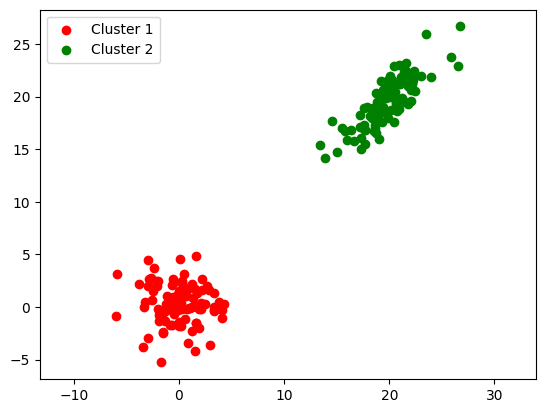

In [22]:
# Let's visualise each cluster and draw the hyperplane (in this case the line) that seperates the two classes
plot_points(points, labels)
plot_margin(w, b)
plt.show()

# Non Separable Case

Let's see what happens when the data is not linearly separable. To visualize this, we will create a new dataset following the same setup from the begining of this tutorial.

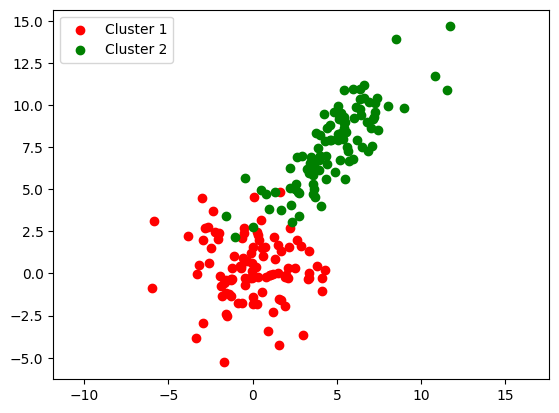

In [23]:
rng = np.random.default_rng(4)  # Random Number Generator

# Let's manually create some clusters
mean = np.array([[0, 0], [5, 8]])  # Mean 2D position of the 2 clusters
major = np.array([2, 3])  # Semi-major axis of the clusters (a)
minor = np.array([2, 1])  # Semi-minor axis of the clusters (b)
angle = np.array([0, pi/4])  # Angle of rotation of the clusters
assert all(minor <= major)

clusters = []
covs = []

for mn, mj, mi, a in zip(mean, major, minor, angle):
    c = np.cos(a) # cosine of the angle
    s = np.sin(a) # sine of the angle
    R = np.array([
        [c,-s],
        [s, c],
    ])  # 2D rotation matrix as per the specified angle
    D = np.array([
        [mj**2, 0],
        [0, mi**2],
    ]) # Diagonal matrix consisting of major and minor axis values
    cov = R @ D @ R.T # Covariance of the ellipse (rotated)
    covs.append(cov)
    clusters.append(
        rng.multivariate_normal(
            mn, cov,
            size=n_points_per_cluster,
        ),  # Generate 100 random points from a multivariant normal with the specified mean and covariance.
    )

points = np.concatenate(clusters, axis=0)  # Concatenate all points in axis 0 resulting in [200, 2] vector.
# Depending on your dataset these points will have the shape of [number of data points, number of features]

#Let's visualize each cluster separately as generated
plot_points(points, labels)
plt.show()

In [32]:
# TODO fill in the following assignments to solve the quadratic equation
n = n_points # total number of data points
f = 200
x = np.random.rand   # data points of shape [n,f] where f is the number of features
y = labels # label values of shape [n]
y = y.astype(float) # solver requires floats not integers
l = 1e-5  # lambda

xy = x*y[:, None]  # shape [n, f]
P =  xy @ xy.T # shape [n, n]
q =  -1*np.ones(n) # shape [n]

A = y[None,:]# shape [n_eq_constr, n]
b = np.zeros(1) # shape [n_eq_constr]

# It is easier to give the inequality constraints via the lb and ub arguments
G = None # shape [n_ineq_constr, n]
h = None # shape [n_ineq_constr]
lb = np.zeros(n)   # shape [n]
ub = (1/(2*n*l)) * np.ones(n)  # shape [n]

c = solve_qp(P, q, G, h, A, b, lb, ub, solver=solver)
# Note when c is closer to zero it is on the correct side fo the boundary and non-zero c represent support vectors.

# Calculate the weights
w = c @ xy # Use equation (5)

# First calculate the support vectors.
# Hint: Support vectors have non-zero c values. We can find them by figuring out how many c values are non-zero (greater than a threshold value).
# Use l as your threshold. We need to go about this way due to floating point issues of zero.
sv = (c > 1) # all values from C vector that are greater than 1
n_support_vectors = len(sv)

# Use equation (6) to calculate b value for each support vector
b_sv = x[sv] @ w - y[sv] #w @ x[sv].T - y[sv]
# TODO If the problem is linearly seperable what can you say about the b values derived from each support vector?


# Let's get the score (class label) for each point as per the SVM solution
# Let's visualize each cluster and draw the hyperplane (in this case the line) that seperates the two classes
plot_points(points, labels)

# Show the hyperplane from each b from each support vector
max = 0
b_ind = 0
for b_i in b_sv:
  slope, y_intercept = calculate_slope_intercept(w, b_i)
  abline(slope, y_intercept)
  pred = np.sign(x @ w - b_i)
  pred = pred.astype(int)

  # TODO calcualate the accuracy
  # Hint: compare predition class labels to actual class labels
  accuracy =  np.mean(pred == labels)
  if accuracy >= max:
    max = accuracy
  print(f'The accuracy of the SVM is {accuracy} for b = {b_i}')

plt.show()

# # Select a b value and show margin
b = b_sv[b_ind]

# Show margin
plot_points(points, labels)
plot_margin(w, b)
plt.show()

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'float'

# Is there a better way to select $b$?

We can use the metrics that we discussed in tutorial 1.

In [ ]:
%pip install sklearn
# sometimes throws an error but works anyway

In [ ]:
# Calculate the metrics explained in tutorial 1
# (using the scikit learn implementations)
from sklearn.metrics import roc_curve, roc_auc_score

score =  x @ w
fpr, tpr, th =
print("AUC:", ...)

# Plot ROC curve to see the effect of b. Mouse over the markers to see the
# threshold (b) value.
# The threshold (b) should be selected such that true positive rate is high and
# the false positive rate is low, but there is a trade-off.
px.line(
    x=fpr, y=tpr, hover_data=dict(Threshold=th),
    markers=True,
    title="ROC curve",
    labels=dict(x="False positive rate", y="True positive rate"),
)

In [ ]:
# Select b and calculate predictions
b = ...
pred = ...

# Calculate the metrics explained in tutorial 1
# (using the scikit learn implementations)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, f1_score, jaccard_score,
)

print("Confusion matrix:", ..., sep='\n')
print("F1 score:", ...)
print("Jaccard score (IoU):", ...)

# Let's visualize each cluster and draw the hyperplane (in this case the line) that seperates the two classes
plot_points(points, labels)
plot_margin(w, b)
plt.show()